In [1]:
import sys
import pandas as pd
import os
import argparse

# Provide a robust ARFF loader: prefer SciPy's arff, fall back to liac-arff if needed.
def _make_arff_loader():
    try:
        from scipy.io import arff as _scipy_arff
        def _load_arff(path):
            return _scipy_arff.loadarff(path)
        return _load_arff
    except Exception:
        try:
            import liac_arff as _liac
            def _load_arff(path):
                with open(path, "r") as f:
                    obj = _liac.load(f)
                # liac-arff returns a dict with keys 'attributes' and 'data'
                return obj.get("data", []), obj.get("attributes", None)
            return _load_arff
        except Exception:
            def _no_loader(path):
                raise RuntimeError("No ARFF loader available. Install 'scipy' or 'liac-arff'.")
            return _no_loader

# create loader function
load_arff = _make_arff_loader()

In [2]:
def load_from_openml(name: str = "mammography", version: int = 1) -> pd.DataFrame:
    """Fetch dataset from OpenML and return a DataFrame with a `class` column.

    This function will attempt to convert target labels of -1 to 0 and leave 1 as-is.
    If scikit-learn is not installed, it will raise an informative error.
    """
    try:
        from sklearn.datasets import fetch_openml
    except Exception as e:
        raise RuntimeError('scikit-learn is required to load from OpenML: ' + str(e))

    data = fetch_openml(name=name, version=version, as_frame=True)
    df = data.frame.copy()

    target_series = None
    if hasattr(data, 'target') and data.target is not None:
        target_series = data.target
    else:
        for candidate in ('class', 'target', 'y'):
            if candidate in df.columns:
                target_series = df[candidate]
                break

    if target_series is not None:
        try:
            t = target_series.astype(int)
        except Exception:
            t = target_series.replace({'-1': -1, '1': 1, '-1.0': -1, '1.0': 1})
            try:
                t = t.astype(int)
            except Exception:
                t = target_series

        try:
            t = t.replace({-1: 0})
        except Exception:
            pass

        df['class'] = t
    else:
        print('Warning: could not find target column in OpenML dataset; saving full frame as-is.')

    return df

In [3]:
def load_from_arff(arff_path: str) -> pd.DataFrame:
    if not os.path.exists(arff_path):
        raise FileNotFoundError(f'ARFF file not found: {arff_path}')

    data, meta = load_arff(arff_path)
    df = pd.DataFrame(data)

    # Normalize a `class` column if present (decode bytes / numeric conversion)
    class_col = None
    for col in df.columns:
        if col.lower() == 'class':
            class_col = col
            break

    if class_col is not None:
        def normalize_label(x):
            if pd.isnull(x):
                return x
            try:
                if hasattr(x, 'decode'):
                    x = x.decode('utf-8')
            except Exception:
                pass
            try:
                xi = int(x)
                if xi == -1:
                    return 0
                return xi
            except Exception:
                return str(x)

        df['class'] = df[class_col].apply(normalize_label)
    else:
        print("Warning: no 'class' column found in ARFF data. Proceeding without decoding step.")

    return df

In [4]:
def main(argv=None):
    parser = argparse.ArgumentParser(description="Load Mammography dataset from ARFF or OpenML and save CSV.")
    parser.add_argument("--openml", action="store_true", help="Fetch dataset from OpenML (default dataset: 'mammography')")
    parser.add_argument("--dataset-name", default="mammography", help="OpenML dataset name to fetch")
    parser.add_argument("--dataset-version", type=int, default=1, help="OpenML dataset version")
    parser.add_argument("--input", default="mp2.arff", help="Local ARFF input path (used when --openml not set)")
    parser.add_argument("--output", default="Mammography.csv", help="CSV output file name")
    args = parser.parse_args(argv)

    if args.openml:
        df = load_from_openml(name=args.dataset_name, version=args.dataset_version)
    else:
        df = load_from_arff(args.input)

    try:
        df.to_csv(args.output, index=False)
    except Exception as e:
        print(f"Failed to write CSV '{args.output}': {e}")
        sys.exit(1)

    print(f"Data saved to {args.output}")

## Example: load local ARFF and save CSV
Run the next cell to load `mp2.arff` (must exist in the workspace) and save `Mammography_from_notebook.csv`.

In [5]:
# Example usage: local ARFF
try:
    df = load_from_arff('mp2.arff')
    display(df.head())
    df.to_csv('Mammography_from_notebook.csv', index=False)
    print('Saved Mammography_from_notebook.csv')
except FileNotFoundError as e:
    print(e)
except Exception as e:
    print('Error while loading ARFF:', e)

,attr1,class
0,1.0,benign
1,2.0,malignant


Saved Mammography_from_notebook.csv


## Example: fetch from OpenML
This cell fetches the Mammography dataset from OpenML (network + scikit-learn required).

In [6]:
# Example usage: OpenML
try:
    df_openml = load_from_openml()
    display(df_openml.head())
    df_openml.to_csv('Mammography_from_openml.csv', index=False)
    print('Saved Mammography_from_openml.csv')
except Exception as e:
    print('OpenML fetch failed:', e)

,attr1,attr2,attr3,attr4,attr5,attr6,class
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,0
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,0
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,0
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,0
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,0


Saved Mammography_from_openml.csv


In [7]:
# Load dataset for analysis: prefer local ARFF, fallback to OpenML
try:
    df = load_from_arff('mp2.arff')
    print('Loaded from local ARFF')
except FileNotFoundError:
    try:
        df = load_from_openml()
        print('Loaded from OpenML')
    except Exception as e:
        raise RuntimeError('Failed to load dataset from ARFF or OpenML: ' + str(e))

print('Data shape:', df.shape)
df.head()

Loaded from local ARFF
Data shape: (2, 2)


,attr1,class
0,1.0,benign
1,2.0,malignant


Numeric columns for plotting: ['attr1', 'attr2', 'attr3', 'attr4', 'attr5', 'attr6']


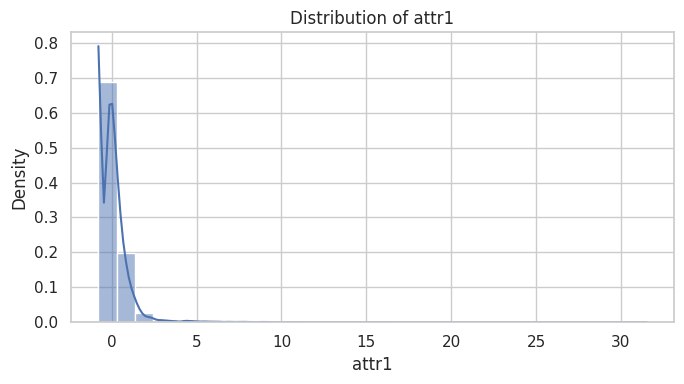

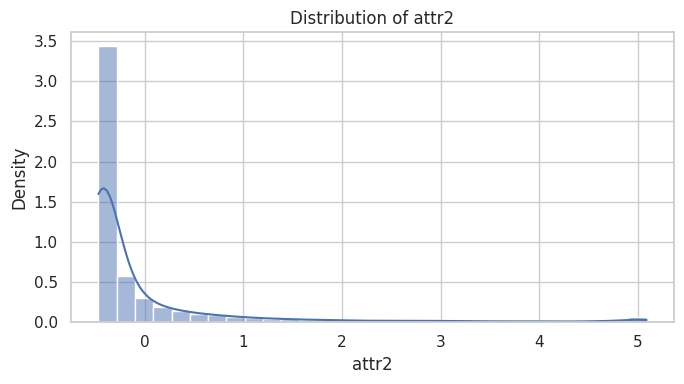

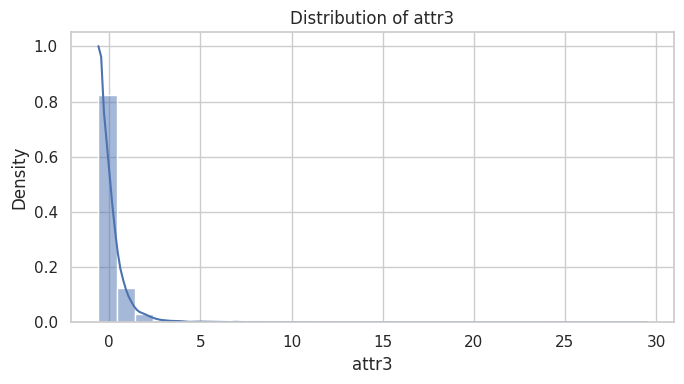

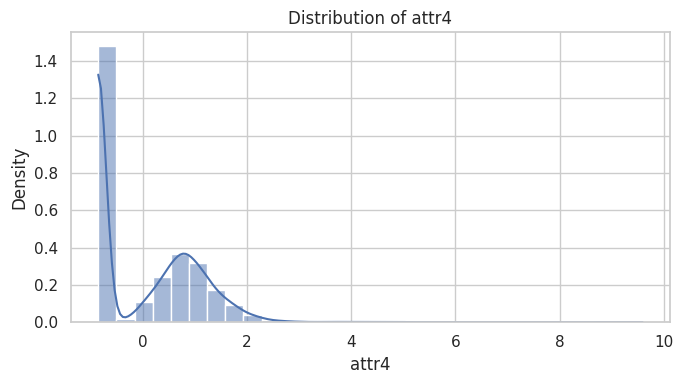

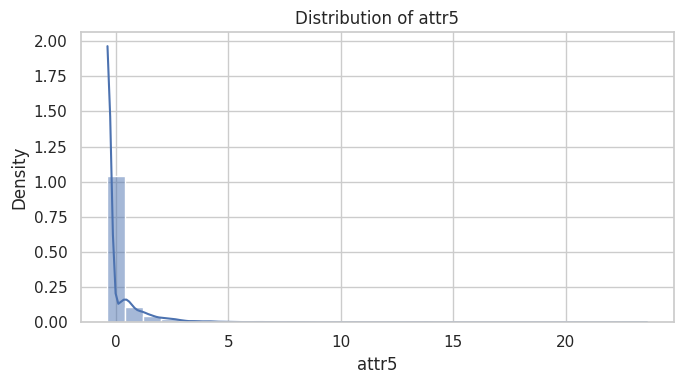

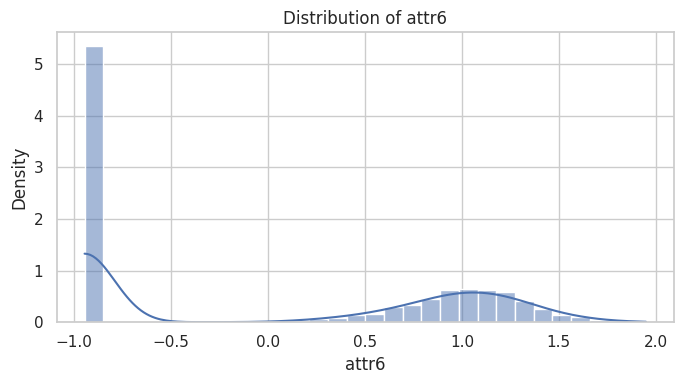

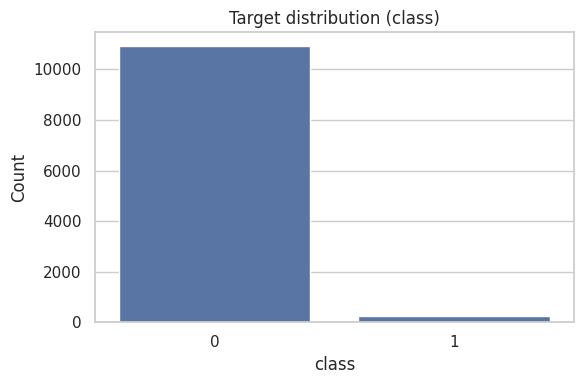

In [8]:
# Visualize univariate distributions for continuous features and the target column
import matplotlib.pyplot as plt
# If the OpenML fetch was run, prefer that dataframe for plotting
if 'df_openml' in globals():
    df = df_openml

# Try to use seaborn if available for nicer plots, otherwise fall back to pandas/matplotlib
try:
    import seaborn as sns
    sns.set(style='whitegrid')
    _use_sns = True
except Exception:
    _use_sns = False

# Select numeric columns (continuous features). Exclude 'class' if present.
num_cols = df.select_dtypes(include=['number']).columns.tolist()
if 'class' in df.columns and 'class' in num_cols:
    try:
        num_cols.remove('class')
    except ValueError:
        pass

print('Numeric columns for plotting:', num_cols)

for col in num_cols:
    plt.figure(figsize=(7,4))
    series = df[col].dropna()
    if series.empty:
        print(f'Column {col} has no non-null values, skipping.')
        continue
    try:
        if _use_sns:
            sns.histplot(series, kde=True, stat='density', bins=30)
        else:
            series.plot.hist(bins=30, density=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f'Could not plot column {col}: {e}')

# Plot the target distribution if present
if 'class' in df.columns:
    plt.figure(figsize=(6,4))
    try:
        if _use_sns:
            sns.countplot(x='class', data=df)
        else:
            df['class'].value_counts().sort_index().plot(kind='bar')
        plt.title('Target distribution (class)')
        plt.xlabel('class')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('Could not plot target distribution:', e)
else:
    print("No 'class' column found in the dataframe; target distribution not plotted.")

## Data split, preprocessing pipeline and Random Forest evaluation
This cell will: split the data into train/test, build a `ColumnTransformer` to scale numeric features and one-hot encode categoricals, create a pipeline with `RandomForestClassifier`, run 5-fold cross-validation on the training set, then evaluate on the test set and save the final pipeline.

In [9]:
# Split, preprocessing pipeline, 5-fold CV and final evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import joblib

# Choose the real dataset if available
df_final = df_openml.copy() if 'df_openml' in globals() else df.copy()

# Coerce the target to binary 0/1 robustly
def coerce_to_binary(s):
    try:
        out = s.astype(int)
        out = out.replace({-1: 0})
        return out.astype(int)
    except Exception:
        mapping = {'benign': 0, 'malignant': 1, 'no': 0, 'yes': 1, '-1': 0, '1': 1}
        out = s.astype(str).str.strip().str.lower().map(mapping)
        return out.astype('Int64')

df_final['class'] = coerce_to_binary(df_final['class'])
df_final = df_final.dropna(subset=['class']).reset_index(drop=True)

# Features / target
X = df_final.drop(columns=['class'])
y = df_final['class'].astype(int)

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print('Numeric columns:', num_cols)
print('Categorical columns:', cat_cols)

# ColumnTransformer: scale numeric, one-hot encode categoricals
# OneHotEncoder changed parameter name in newer sklearn versions (sparse -> sparse_output).
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_cols),
        ('cat', ohe, cat_cols),
    ],
    remainder='drop'
)

# Full pipeline with Random Forest
pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
])

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# 5-fold cross-validation on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'roc_auc', 'f1']
cv_results = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

# Print CV results
for k in scoring:
    vals = cv_results['test_' + k]
    print(f'CV {k}: mean={vals.mean():.4f}, std={vals.std():.4f}')

# Fit on full training set and evaluate on test set
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, 'predict_proba') else None

print('\nTest set results:' )
print('Accuracy:', accuracy_score(y_test, y_pred))
if y_proba is not None:
    try:
        print('ROC AUC:', roc_auc_score(y_test, y_proba))
    except Exception as e:
        print('ROC AUC computation failed:', e)
print('\nClassification report:\n', classification_report(y_test, y_pred))

# Save the trained pipeline
joblib.dump(pipe, 'rf_pipeline.joblib')
print('Saved pipeline to rf_pipeline.joblib')

Numeric columns: ['attr1', 'attr2', 'attr3', 'attr4', 'attr5', 'attr6']
Categorical columns: []
Train shape: (8946, 6) Test shape: (2237, 6)
CV accuracy: mean=0.9878, std=0.0011
CV roc_auc: mean=0.9310, std=0.0358
CV f1: mean=0.6707, std=0.0294

Test set results:
Accuracy: 0.986142154671435
ROC AUC: 0.9824282696708326

Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2185
           1       0.86      0.48      0.62        52

    accuracy                           0.99      2237
   macro avg       0.92      0.74      0.81      2237
weighted avg       0.98      0.99      0.98      2237

Saved pipeline to rf_pipeline.joblib


## Hyperparameter tuning with GridSearchCV
We tune two models: RandomForest and LogisticRegression using `GridSearchCV` (ROC AUC scoring). Results and heatmaps will be saved.

Running GridSearchCV for RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Running GridSearchCV for LogisticRegression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
RandomForest best ROC AUC: 0.9439479581861938
RandomForest best params: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__n_estimators': 100}
LogisticRegression best ROC AUC: 0.9155017175026146
LogisticRegression best params: {'clf__C': 1.0, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2'}
Saved grid search objects to gscv_rf.joblib and gscv_lr.joblib


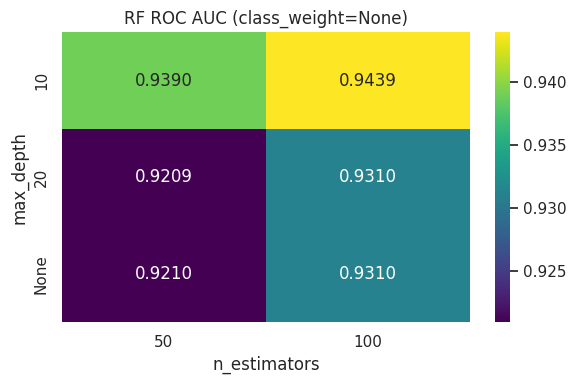

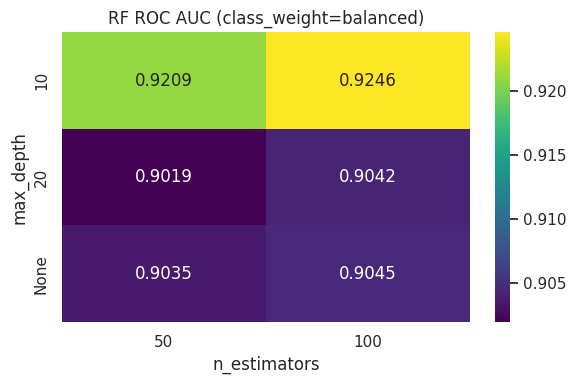

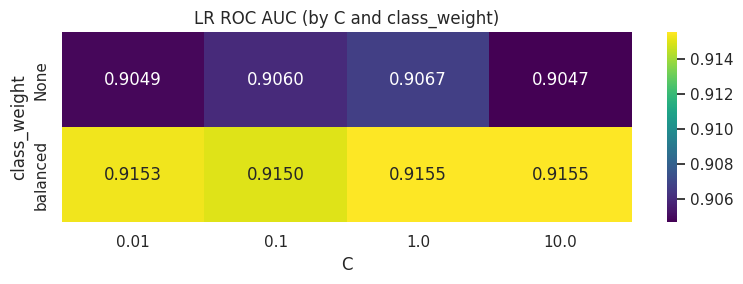

Previous untuned RF ROC AUC (train CV): 0.9310
Tuned RF ROC AUC (train CV): 0.9439


In [10]:
# Grid search for RandomForest and LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure training data exists (recreate split if necessary)
if 'X_train' not in globals():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Pipelines for both models (reuse preprocessor)
pipe_rf = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))])
pipe_lr = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=2000, solver='liblinear'))])

# Parameter grids (keep them small to limit runtime)
param_grid_rf = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10, 20],
    'clf__class_weight': [None, 'balanced'],
}
param_grid_lr = {
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__penalty': ['l2'],
    'clf__class_weight': [None, 'balanced'],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gscv_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
gscv_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)

print('Running GridSearchCV for RandomForest...')
gscv_rf.fit(X_train, y_train)
print('Running GridSearchCV for LogisticRegression...')
gscv_lr.fit(X_train, y_train)

print('RandomForest best ROC AUC:', gscv_rf.best_score_)
print('RandomForest best params:', gscv_rf.best_params_)
print('LogisticRegression best ROC AUC:', gscv_lr.best_score_)
print('LogisticRegression best params:', gscv_lr.best_params_)

# Save grid search objects
joblib.dump(gscv_rf, 'gscv_rf.joblib')
joblib.dump(gscv_lr, 'gscv_lr.joblib')
print('Saved grid search objects to gscv_rf.joblib and gscv_lr.joblib')

# Prepare results for visualization
rf_res = pd.DataFrame(gscv_rf.cv_results_)
rf_res['n_estimators'] = rf_res['param_clf__n_estimators'].astype(int)
rf_res['max_depth'] = rf_res['param_clf__max_depth'].astype(str)
rf_res['class_weight'] = rf_res['param_clf__class_weight'].astype(str)

# Plot heatmaps for RandomForest varying n_estimators x max_depth for each class_weight
for cw in rf_res['class_weight'].unique():
    sub = rf_res[rf_res['class_weight'] == cw]
    pivot = sub.pivot_table(index='max_depth', columns='n_estimators', values='mean_test_score')
    plt.figure(figsize=(6,4))
    sns.heatmap(pivot, annot=True, fmt='.4f', cmap='viridis')
    plt.title(f'RF ROC AUC (class_weight={cw})')
    plt.ylabel('max_depth')
    plt.xlabel('n_estimators')
    plt.tight_layout()
    plt.show()

# Logistic Regression results
lr_res = pd.DataFrame(gscv_lr.cv_results_)
lr_res['C'] = lr_res['param_clf__C'].astype(float)
lr_res['class_weight'] = lr_res['param_clf__class_weight'].astype(str)
pivot_lr = lr_res.pivot_table(index='class_weight', columns='C', values='mean_test_score')
plt.figure(figsize=(8,3))
sns.heatmap(pivot_lr, annot=True, fmt='.4f', cmap='viridis')
plt.title('LR ROC AUC (by C and class_weight)')
plt.xlabel('C')
plt.ylabel('class_weight')
plt.tight_layout()
plt.show()

# Compare to baseline (previous RF training without tuning) if available
try:
    prev_rf_score = None
    if 'cv_results' in globals():
        # earlier CV was stored in variable cv_results (for the untuned pipe)
        if 'test_roc_auc' in cv_results:
            prev_rf_score = cv_results['test_roc_auc'].mean()
    if prev_rf_score is not None:
        print(f'Previous untuned RF ROC AUC (train CV): {prev_rf_score:.4f}')
        print(f'Tuned RF ROC AUC (train CV): {gscv_rf.best_score_:.4f}')
except Exception as e:
    print('Could not compare to previous results:', e)

## Confusion matrices for tuned models
Evaluate the best estimators from the GridSearchCV objects on the held-out test set and display confusion matrices and classification reports.

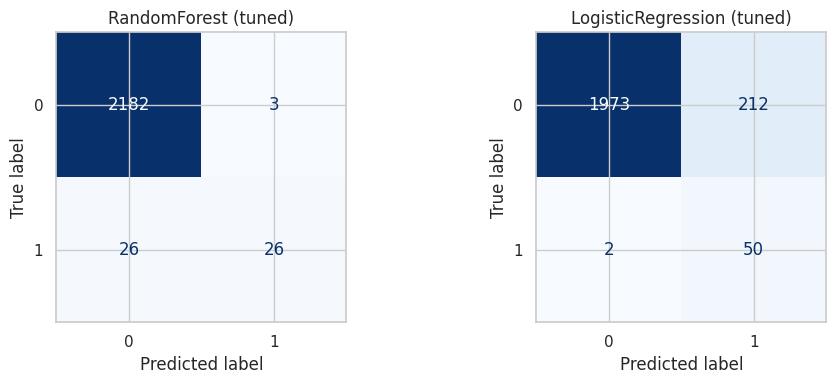

RandomForest classification report
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2185
           1       0.90      0.50      0.64        52

    accuracy                           0.99      2237
   macro avg       0.94      0.75      0.82      2237
weighted avg       0.99      0.99      0.99      2237

LogisticRegression classification report
               precision    recall  f1-score   support

           0       1.00      0.90      0.95      2185
           1       0.19      0.96      0.32        52

    accuracy                           0.90      2237
   macro avg       0.59      0.93      0.63      2237
weighted avg       0.98      0.90      0.93      2237



In [11]:
# Confusion matrices and classification reports for tuned models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import joblib

# Load or reference trained GridSearchCV objects
if 'gscv_rf' not in globals():
    gscv_rf = joblib.load('gscv_rf.joblib')
if 'gscv_lr' not in globals():
    gscv_lr = joblib.load('gscv_lr.joblib')

best_rf = gscv_rf.best_estimator_
best_lr = gscv_lr.best_estimator_

# Ensure test split exists
if 'X_test' not in globals():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Predict on test set
y_pred_rf = best_rf.predict(X_test)
y_pred_lr = best_lr.predict(X_test)

# Confusion matrices
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_lr = confusion_matrix(y_test, y_pred_lr)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[0,1])
disp_rf.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('RandomForest (tuned)')

disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=[0,1])
disp_lr.plot(ax=axes[1], cmap='Blues', colorbar=False)
axes[1].set_title('LogisticRegression (tuned)')

plt.tight_layout()
plt.show()

# Print classification reports
print('RandomForest classification report\n', classification_report(y_test, y_pred_rf))
print('LogisticRegression classification report\n', classification_report(y_test, y_pred_lr))

## Experiment: KFold (shuffle) sensitivity
We change the cross-validation strategy from StratifiedKFold to KFold with shuffling.
We will: (1) run GridSearchCV for RandomForest using KFold(shuffle=True) with several CV random seeds;
(2) vary the train/test split random_state; (3) collect best params and scores to see stability.

In [12]:
# KFold sensitivity experiment
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import pandas as pd, numpy as np
import joblib

# Ensure data X, y exist
if 'X' not in globals():
    # Prefer `df_openml`, fall back to `df`; if neither exists, try to fetch from OpenML
    if 'df_openml' in globals():
        df_source = df_openml.copy()
    elif 'df' in globals():
        df_source = df.copy()
    else:
        if 'load_from_openml' in globals():
            df_source = load_from_openml()
            print('Fetched dataset from OpenML via load_from_openml()')
        else:
            from sklearn.datasets import fetch_openml
            data = fetch_openml(name='mammography', version=1, as_frame=True)
            df_source = data.frame.copy()
            print('Fetched dataset from OpenML via sklearn.fetch_openml()')
    # Coerce/normalize `class` column to integer 0/1
    try:
        df_source['class'] = df_source['class'].astype(int).replace({-1: 0}).astype(int)
    except Exception:
        mapping = {'benign': 0, 'malignant': 1, 'no': 0, 'yes': 1, '-1': 0, '1': 1}
        df_source['class'] = df_source['class'].astype(str).str.strip().str.lower().map(mapping)
        df_source = df_source.dropna(subset=['class']).reset_index(drop=True)
        df_source['class'] = df_source['class'].astype(int)
    X = df_source.drop(columns=['class'])
    y = df_source['class'].astype(int)

# Parameter grid (same as before for RF)
param_grid_rf = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10, 20],
    'clf__class_weight': [None, 'balanced'],
}

# Use the same preprocessor defined earlier; fall back to building it if missing
try:
    pre = preprocessor
except NameError:
    # recreate compatible preprocessor
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    num_cols = X.select_dtypes(include=['number']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    pre = ColumnTransformer([('num', StandardScaler(), num_cols), ('cat', ohe, cat_cols)], remainder='drop')

# Seeds to try
cv_seeds = [0, 1, 42, 99]
split_seeds = [0, 1, 42]
results = []

for split_seed in split_seeds:
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=split_seed)
    for cv_seed in cv_seeds:
        kf = KFold(n_splits=5, shuffle=True, random_state=cv_seed)
        pipe = Pipeline([('pre', pre), ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))])
        g = GridSearchCV(pipe, param_grid_rf, cv=kf, scoring='roc_auc', n_jobs=-1, verbose=0)
        g.fit(X_tr, y_tr)
        best = g.best_params_
        results.append({
            'split_seed': split_seed,
            'cv_seed': cv_seed,
            'best_n_estimators': int(best['clf__n_estimators']),
            'best_max_depth': str(best['clf__max_depth']),
            'best_class_weight': str(best['clf__class_weight']),
            'best_score': g.best_score_
        })

res_df = pd.DataFrame(results)
print('Experiment results (KFold with shuffle)')
display(res_df)

# Summarize stability: group by parameter and count unique settings
print('\nParameter stability summary:')
print(res_df.groupby(['best_n_estimators','best_max_depth','best_class_weight']).size())

# Save results
res_df.to_csv('kfold_experiment_results.csv', index=False)
print('Saved results to kfold_experiment_results.csv')


Experiment results (KFold with shuffle)


,split_seed,cv_seed,best_n_estimators,best_max_depth,best_class_weight,best_score
0,0,0,100,10,None,0.955366
1,0,1,100,10,None,0.952105
2,0,42,100,10,None,0.961155
3,0,99,100,10,None,0.955567
4,1,0,50,10,None,0.948523
5,1,1,100,10,None,0.945775
6,1,42,100,10,None,0.943467
7,1,99,100,10,None,0.948977
8,42,0,100,10,None,0.941523
9,42,1,100,10,None,0.951315



Parameter stability summary:
best_n_estimators  best_max_depth  best_class_weight
50                 10              None                  2
100                10              None                 10
dtype: int64
Saved results to kfold_experiment_results.csv
